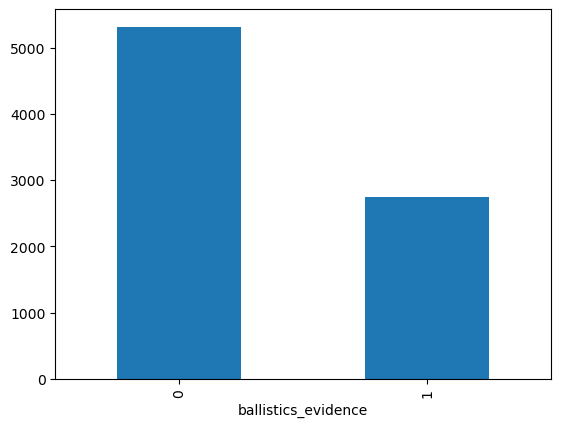

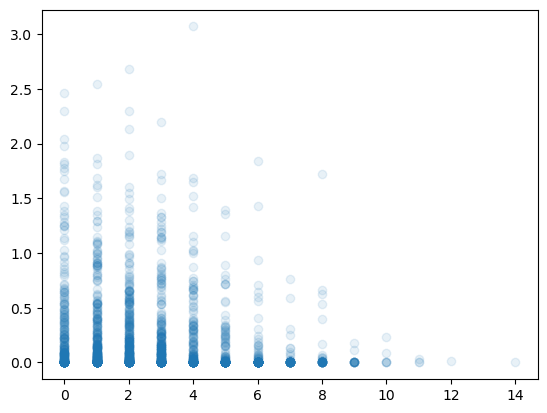

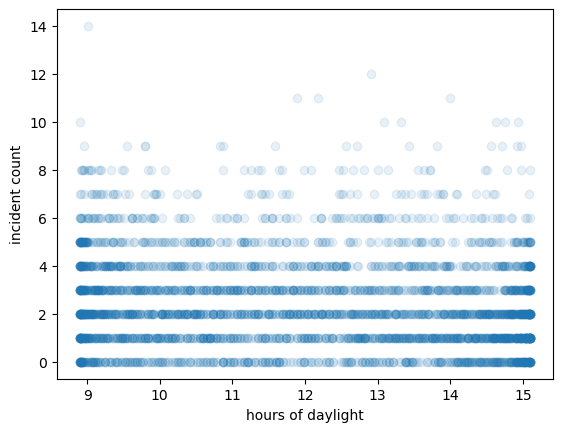

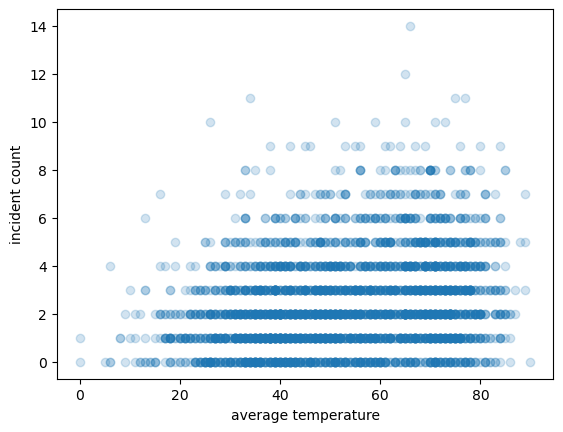

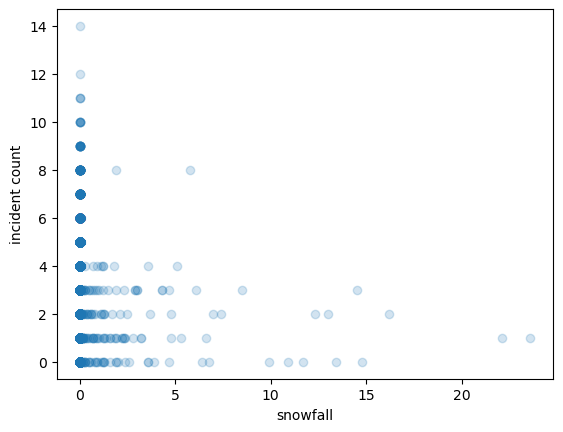

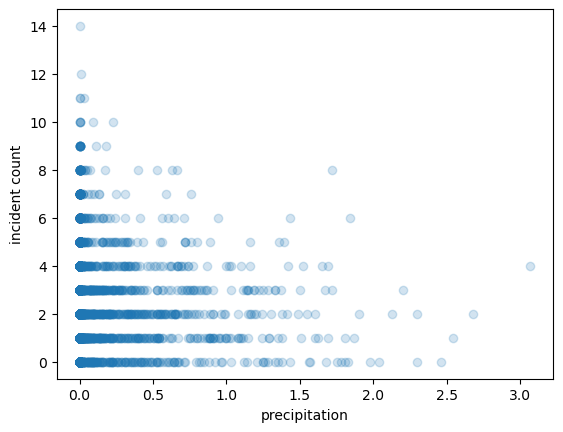

/var/folders/5x/1n063tsx6jx9wzcy34jzlqzh0000gn/T/ipykernel_41115/3579789719.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shots_daily_weather = shots_daily_weather.groupby(['day_of_week']).mean().reset_index()


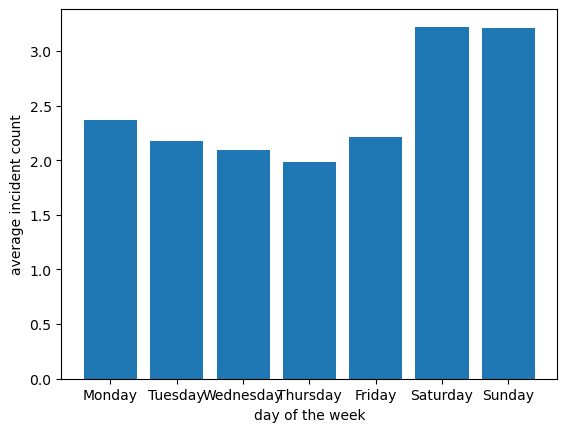

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

%run 'ShotsFired_EDA_aggregate_samples.ipynb'

In [2]:
# browsing our pipeline
shots_daily.head()

,DATE,AWND,PRCP,SNOW,TAVG,district,ballistics_evidence,incident_count,daylight_hours,day_of_week,weekend,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday
0,2015-01-01,14.32,0.00,0.0,26,C11A15,0.0,2.0,12.488967,Thursday,False,False,False,False,True,False,False,False
1,2015-01-02,12.75,0.00,0.0,34,B3E13,1.0,2.0,12.537565,Friday,False,False,False,False,False,True,False,False
2,2015-01-03,10.29,0.62,1.4,28,B2,0.0,1.0,12.586077,Saturday,True,False,False,False,False,False,True,False
3,2015-01-04,8.28,0.57,0.0,38,B2B2,1.0,2.0,12.634493,Sunday,True,False,False,False,False,False,False,True
4,2015-01-05,22.15,0.00,0.0,40,C6,0.0,1.0,12.682807,Monday,False,True,False,False,False,False,False,False


In [3]:
shot_count = 3

# aggregating our labels to see where we can find a signal
shots_daily['incident_count'] = shots_daily['incident_count'].replace(
    [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 
    '2.0')

# helpful to see how many samples we have for each class
# as i play around with the number of shots to aggregate
print(shots_daily['incident_count'].value_counts())

incident_count
2.0    2094
1.0     712
0.0     465
Name: count, dtype: int64


In [4]:
# variables for X and y

X = shots_daily[['TAVG', 'PRCP', 'SNOW', 'AWND', 'daylight_hours', 
                 'is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday',
                   'is_Friday', 'is_Saturday', 'is_Sunday']]

y = shots_daily['incident_count']

print('X shape is', X.shape)
print('y shape is', y.shape)

X shape is (3271, 12)
y shape is (3271,)


In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [6]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [7]:
# Calculating class weights, since we have far more
# shooting days than non-shooting days
class_weights = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(y_train),
                                    y=y_train)

# Converting class weights to a dictionary
class_weights_dict = dict(enumerate(class_weights))

In [8]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')

y_train = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test.reshape(-1, 1)).toarray()

print('y_train shape is', y_train.shape)
print('y_test shape is', y_test.shape)

y_train shape is (2453, 3)
y_test shape is (818, 3)


In [9]:
print('Verifying shapes:')
print('X_train shape is', X_train.shape)
print('y_train shape is', y_train.shape)
print('X_test shape is', X_test.shape)
print('y_test shape is', y_test.shape)

Verifying shapes:
X_train shape is (2453, 12)
y_train shape is (2453, 3)
X_test shape is (818, 12)
y_test shape is (818, 3)


In [10]:
model = keras.Sequential([
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(shot_count, activation='softmax')
    ])

In [11]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [12]:
callback_val_loss = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=50,
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=20,
    min_lr=0.0001
)

In [13]:
batch_size = 16
epochs = 100

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[callback_val_loss, reduce_lr],
                    # class_weight=class_weights_dict,
                    validation_split=0.1
                    )

Epoch 1/100
138/138 [==============================] - 0s 1ms/step - loss: 0.8738 - accuracy: 0.6570 - val_loss: 0.6866 - val_accuracy: 0.7520 - lr: 0.0100
Epoch 2/100
138/138 [==============================] - 0s 462us/step - loss: 0.8472 - accuracy: 0.6593 - val_loss: 0.6931 - val_accuracy: 0.7520 - lr: 0.0100
Epoch 3/100
138/138 [==============================] - 0s 454us/step - loss: 0.8425 - accuracy: 0.6597 - val_loss: 0.7164 - val_accuracy: 0.7520 - lr: 0.0100
Epoch 4/100
138/138 [==============================] - 0s 459us/step - loss: 0.8397 - accuracy: 0.6602 - val_loss: 0.6848 - val_accuracy: 0.7520 - lr: 0.0100
Epoch 5/100
138/138 [==============================] - 0s 460us/step - loss: 0.8360 - accuracy: 0.6606 - val_loss: 0.6804 - val_accuracy: 0.7398 - lr: 0.0100
Epoch 6/100
138/138 [==============================] - 0s 451us/step - loss: 0.8342 - accuracy: 0.6584 - val_loss: 0.6997 - val_accuracy: 0.7317 - lr: 0.0100
Epoch 7/100
138/138 [==============================] -

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 3491 (13.64 KB)
Trainable params: 3491 (13.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model.evaluate(X_test, y_test, verbose=2)

26/26 - 0s - loss: nan - accuracy: 0.5501 - 17ms/epoch - 640us/step


[nan, 0.5501222610473633]

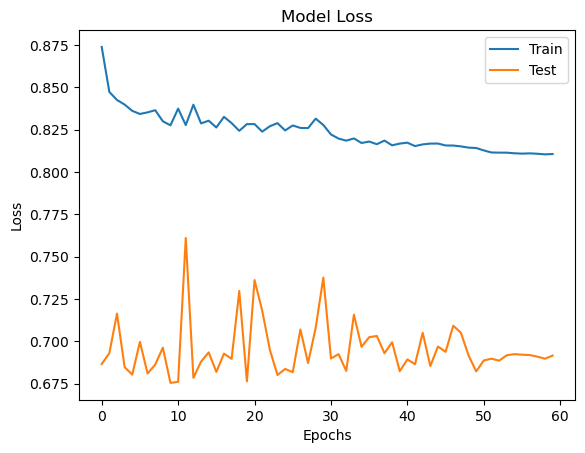

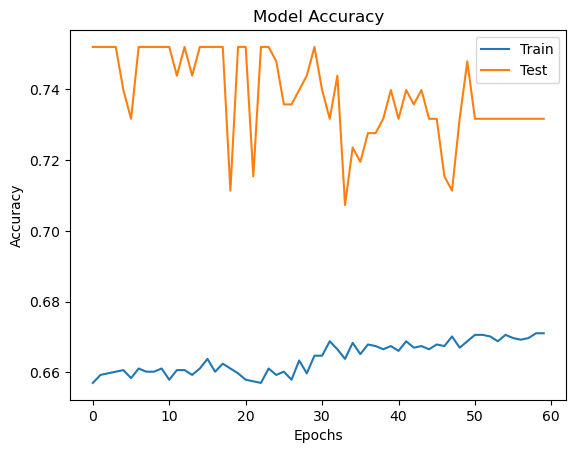

In [16]:
# plotting performance
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

In [17]:
# idea: we could try  and build models for every district, since different districts may have different trends
# we might be mixing too many trends here and that's why our model is not performing well

In [18]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

confusion_matrix(y_test, y_pred)

26/26 [==============================] - 0s 374us/step


array([[  6,   0, 138],
       [  8,   0, 214],
       [  8,   0, 444]])

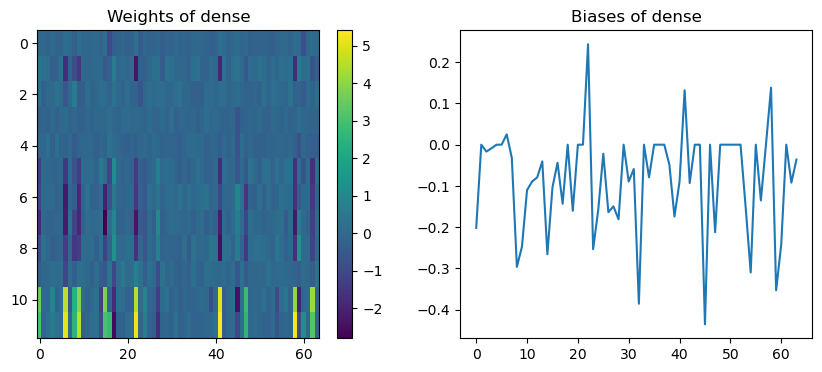

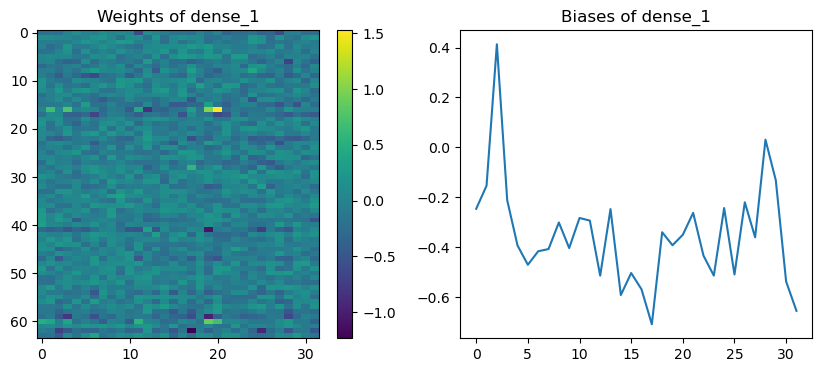

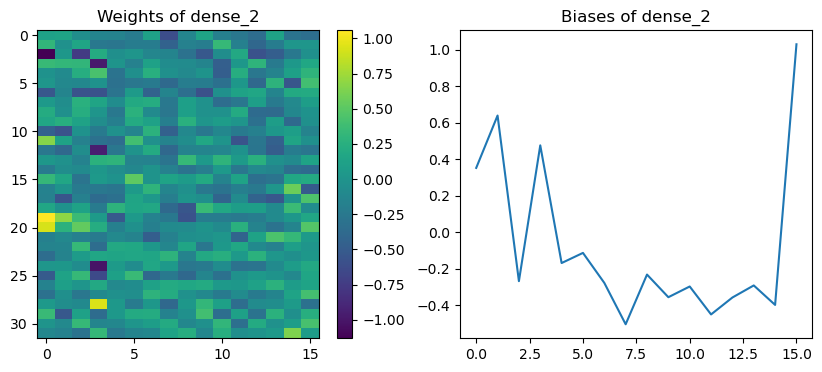

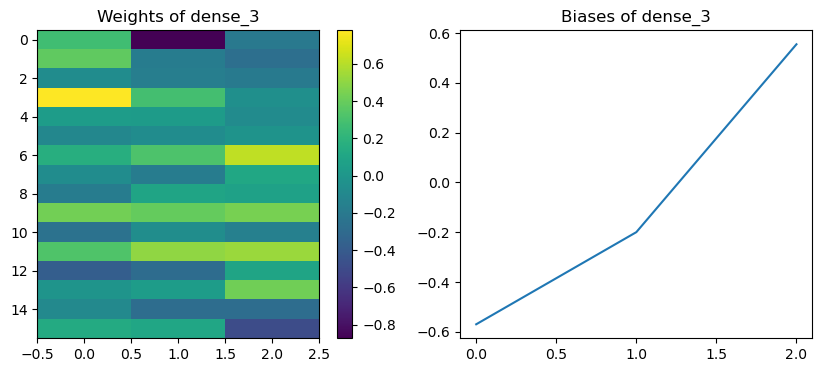

In [19]:
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Keras model
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        # weights[0] are the weights, weights[1] are the biases (if present)
        plt.figure(figsize=(10, 4))

        # Plotting the weights
        plt.subplot(1, 2, 1)
        plt.imshow(weights[0], aspect='auto', cmap='viridis')
        plt.colorbar()
        plt.title(f"Weights of {layer.name}")

        # Plotting the biases if they exist
        if len(weights) > 1:
            plt.subplot(1, 2, 2)
            plt.plot(weights[1])
            plt.title(f"Biases of {layer.name}")

        plt.show()


In [20]:
# recording our results
# 3 labels: 55.3% accuracy
# 4 labels: 31.66% accuracy
# 5 labels: 22.13% accuracy
# 6 labels: 20.78% accuracy
# 7 labels: 26% accuracy
# 8 labels: 24.8% accuracy
# 9 labels: 24.9% accuracy
# 10 labels: 24.8% accuracy
# 11 labels: 25.18% accuracy
# 12 labels: 25.67% accuracy
# 13 labels: 25.41% accuracy